## First use CHO cells and gather all the peaks. 

### Use PCA , (keeping only certain amount of components )
See if any of the PCs correspond to distance from anno. 
So marker-size or gradient based on distance

Otherwise select small and large size distances as promoter vs enhancer and use logistic regression (or LDA) to distinguish the two. 

In [21]:
import yaml
config = "motif_params_1.yaml"
with open(config,'r') as f:
    motif_params = yaml.load(f)

    
print(motif_params)

{'motif_outlier': 'None', 'out_f': None, 'name': 'processed/CHO_GROCap1_GRO1', 'ncomp': 10, 'dim_red': 'svd', 'motif_list': '()', 'peak_outlier': 0, 'peak_z_outlier': True, 'cluster_alg': 'hdb', 'class_alg': 'None', 'group_names': ['Promoter', 'Enhancer'], 'group_files': ['processed/sample_CHO_GROCap1_and_CHO_GRO1.tsv', 'processed/enhancer_CHO_GROCap1_and_CHO_GRO1'], 'norm': 'None'}


In [1]:
## Parameters specific to where your folders are and your data
parameter_file = '../params/params.yaml'
import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
anno_gff=doc['annotation']
mRNA_peak_file = doc["mRNA_peak_file"]
mRNA_peak_150_file = doc["mRNA_peak_150_file"]
supplemental = doc["supplemental"]
tss_annotation = doc['tss_annotation']
import annotation
import os
os.chdir
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm
import time

from os.path import basename
##mpl.use('Agg')
#mpl.style.use('ggplot')
#mpl.style.use('fivethirtyeight')
from Homer import *
from create_output import *
print('Number of tissues: ',len(tissues))

('Number of tissues: ', 13)


In [2]:
from sklearn.decomposition import TruncatedSVD
from scipy import sparse as sp

In [3]:
if not os.path.exists("processed"):
    os.mkdir("processed")

## Read and format CHO matrix data

In [4]:
fimo_df = pd.read_csv("/data/isshamie/TSS/Analysis/Analysis_NCBI_PICR/Results/Figures/SuppFigure3/CHO_GROCap1_and_CHO_GRO1/fimo.tsv",sep="\t")

# The last three rows are just comments for some reason. Need to remove. 
fimo_df = fimo_df[~fimo_df["motif_id"].str.contains("^#")]

fimo_df

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,gfy-staf.motif,NaN,NW_020822501.1-84,55.0,74.0,-,31.7636,8.250000e-13,0.000010,GACTACAATTCCCAGAAGGC
1,ronin.motif,NaN,NW_020822533.1-74,32.0,51.0,-,30.4364,1.230000e-12,0.000009,GACTACAACTCCCAGAAGGC
2,ronin.motif,NaN,NW_020822651.1-8,60.0,79.0,-,30.4364,1.230000e-12,0.000009,GACTACAACTCCCAGAAGGC
3,gfy-staf.motif,NaN,NW_020822601.1-200,18.0,37.0,+,31.7455,1.830000e-12,0.000010,AACTACAATTCCCAGAAGGC
4,gfy-staf.motif,NaN,NW_020822601.1-1702,43.0,62.0,-,31.7455,1.830000e-12,0.000010,AACTACAATTCCCAGAAGGC
5,ronin.motif,NaN,NW_020822598.1-83,54.0,73.0,+,30.1212,1.910000e-12,0.000009,AACTACAACTCCCAGCAGGC
6,ronin.motif,NaN,NW_020822461.1-205,110.0,129.0,-,30.1152,2.470000e-12,0.000009,GACTACAACTCCCAGGAGGC
7,boris.motif,NaN,NW_020822603.1-494,67.0,86.0,+,25.3515,2.820000e-12,0.000045,CTCGGGCGCCCCCTGGTGGC
8,ronin.motif,NaN,NW_020822598.1-136,44.0,63.0,-,30.0182,3.290000e-12,0.000009,AACTACAACTCCCAGAAGGC
9,ronin.motif,NaN,NW_020822577.1-23,18.0,37.0,+,29.9939,3.970000e-12,0.000009,GACTACAACTCCCAGCATGC


### Load in CHO peak data

In [5]:
peak_f = os.path.join(data_folder,"CHO/GROCap/f04_peaks/trim_CHO_GROCap1_and_trim_CHO_GRO1_bg_2.peak")
peaks = read_peak_file(peak_f)
peaks

,Chr,Start,End,Strand,Normalized Tag Count,focus ratio,findPeaks Score,Total Tags (normalized to Control Experiment),Control Tags,Fold Change vs Control,p-value vs Control,Fold Change vs Local,p-value vs Local,Dispersion Ratio,Periodic Ratio
#PeakID,,,,,,,,,,,,,,,
NW_020822465.1-1,NW_020822465.1,12601780,12601930,+,3959.200,0.920,105445.0,82497.3,8891.0,9.28,0.000000,9985.41,0.000000e+00,0.860768,0.510682
NW_020822391.1-1,NW_020822391.1,705573,705723,+,887.100,0.891,23648.0,18485.0,7306.0,2.53,0.000000,2692.68,0.000000e+00,0.859391,0.392157
NW_020822519.1-1,NW_020822519.1,30535313,30535463,+,821.900,0.886,22669.0,17125.6,5189.0,3.30,0.000000,335.22,0.000000e+00,0.919301,0.543109
NW_020822618.1-1,NW_020822618.1,4328685,4328835,-,737.300,0.991,19598.0,15363.1,4836.0,3.18,0.000000,6598.99,0.000000e+00,0.996479,0.275362
NW_020822465.1-2,NW_020822465.1,12627307,12627457,+,639.400,0.929,17120.0,13324.0,2049.0,6.50,0.000000,763.86,0.000000e+00,0.896852,0.575585
NW_020822603.1-1,NW_020822603.1,6596025,6596175,-,576.000,0.883,15325.0,12002.9,1236.0,9.71,0.000000,209.10,0.000000e+00,0.949442,0.316537
NW_020822537.1-1,NW_020822537.1,754291,754441,+,556.100,0.987,14784.0,11587.4,387.0,29.94,0.000000,4275.57,0.000000e+00,0.941475,0.523699
NW_020822567.1-1,NW_020822567.1,9245121,9245271,-,509.500,0.955,13550.0,10616.8,2304.0,4.61,0.000000,71.75,0.000000e+00,0.963001,0.467066
NW_020822601.1-1,NW_020822601.1,37658448,37658598,-,473.200,0.834,12607.0,9859.5,1809.0,5.45,0.000000,3877.11,0.000000e+00,0.946167,0.500739


In [6]:
peak_by_motif = pd.DataFrame(0,index=peaks.index,columns=np.unique(fimo_df["motif_id"].values),dtype='int64')
peak_by_motif

,ap1.motif,ap2.motif,ap2gamma.motif,ap4.motif,ar-half.motif,are-fox.motif,are.motif,arnt.motif,ascl1.motif,atf1.motif,...,znf467.motif,znf519.motif,znf528.motif,znf652.motif,znf669.motif,znf675.motif,znf692.motif,znf7.motif,znf711.motif,zscan22.motif
#PeakID,,,,,,,,,,,,,,,,,,,,,
NW_020822465.1-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NW_020822391.1-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NW_020822519.1-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NW_020822618.1-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NW_020822465.1-2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NW_020822603.1-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NW_020822537.1-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NW_020822567.1-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NW_020822601.1-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Get Distance to TSS for CHO peaks


In [13]:
landmark_df = pd.read_csv(tss_annotation, sep="\t", index_col=0)
anno_df = annotation.distance_to_landmarks(peaks, landmark_df, main_landmark='transcript_id',
                          landmark_cols=())


/data/isshamie/TSS/Analysis/src/annotation.py:114: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  filt2 = np.abs(filt['actual_start'] - peak_start).argmin()
/data/isshamie/TSS/Analysis/src/annotation.py:115: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  anno_peaks.set_value(ind, 'Nearest TSS', landmark_df.loc[filt2, main_landmark])
/data/isshamie/TSS/Analysis/src/annotation.py:126: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  anno_peaks.set_value(ind, 'Distance to TSS', landmark_df.loc[filt2, 'actual_start'] - peak_start)
/data/isshamie/TSS/Analysis/src/annotation.py:127: FutureWar

In [14]:
anno_df.to_csv("processed/CHO_GROCap1_GRO1.anno",sep="\t")
anno_df.head()

,Chr,Start,End,Strand,Normalized Tag Count,focus ratio,findPeaks Score,Total Tags (normalized to Control Experiment),Control Tags,Fold Change vs Control,p-value vs Control,Fold Change vs Local,p-value vs Local,Dispersion Ratio,Periodic Ratio,Nearest TSS,Distance to TSS,isSameStrand
#PeakID,,,,,,,,,,,,,,,,,,
NW_020822465.1-1,NW_020822465.1,12601780,12601930,+,3959.2,0.920,105445.0,82497.3,8891.0,9.28,0.0,9985.41,0.0,0.860768,0.510682,NM_001246742.1,-24672.0,False
NW_020822391.1-1,NW_020822391.1,705573,705723,+,887.1,0.891,23648.0,18485.0,7306.0,2.53,0.0,2692.68,0.0,0.859391,0.392157,XM_027389096.1,-326.0,False
NW_020822519.1-1,NW_020822519.1,30535313,30535463,+,821.9,0.886,22669.0,17125.6,5189.0,3.30,0.0,335.22,0.0,0.919301,0.543109,XM_027411336.1,-18627.0,False
NW_020822618.1-1,NW_020822618.1,4328685,4328835,-,737.3,0.991,19598.0,15363.1,4836.0,3.18,0.0,6598.99,0.0,0.996479,0.275362,XM_027428396.1,21529.0,True
NW_020822465.1-2,NW_020822465.1,12627307,12627457,+,639.4,0.929,17120.0,13324.0,2049.0,6.50,0.0,763.86,0.0,0.896852,0.575585,NM_001246742.1,-50199.0,False


### Convert to count matrix

In [7]:
%%time
for m, curr in tqdm.tqdm_notebook(fimo_df.groupby("motif_id")):
    print(m)
    seqs = curr.groupby("sequence_name")
    peak_by_motif.loc[seqs.groups.keys(),m] = seqs.size()

ap1.motif
ap2.motif
ap2gamma.motif
ap4.motif
ar-half.motif
are-fox.motif
are.motif
arnt.motif
ascl1.motif
atf1.motif
atf2.motif
atf3.motif
atf4.motif
atf7.motif
atoh1.motif
bach1.motif
bach2.motif
bapx1.motif
barx1.motif
batf.motif
batf3-irf8.motif
bcl6.motif
bhlhe40.motif
bmal.motif
bmyb.motif
boris.motif
brachyury.motif
brn1.motif
brn2.motif
bzip-irf.motif
cMyc.lncap.motif
cdx2.motif
cdx4.motif
cebp-ap1.motif
cebp-cebp.motif
cebp.motif
chop.motif
chr.motif
clock.motif
cmyc.motif
couptf1.motif
couptf2.motif
cre.motif
crx.motif
ctcf-mys.motif
ctcf.motif
cux2.motif
dmc1.motif
dmrt1.motif
dmrt6.motif
dr0.motif
dr5.motif
dux4.motif
e2a.motif
e2f.motif
e2f1.motif
e2f3.motif
e2f4.motif
e2f6.motif
e2f7.motif
e47.motif
ebf-old.motif
ebf.motif
ebna1.motif
ebox.motif
egr1.motif
egr2.motif
ehf.motif
eklf.motif
elf1.motif
elf3.motif
elf5.motif
elk1.motif
elk4.motif
eomes.motif
ere.motif
erg.motif
erra.motif
es.motif
esrrb.motif
ets-distal.motif
ets-ebox.motif
ets-runx.motif
ets.motif
ets1.motif
e

## Save peak_by_motif
## Save peaks here as well

In [15]:
peak_by_motif.to_csv("processed/CHO_GROCap1_GRO1.motifCount",sep="\t")

## Get stats on sparsity and counts

('Number of nonzero entries:', 1694416)
('Density:', 0.058707667403970355)


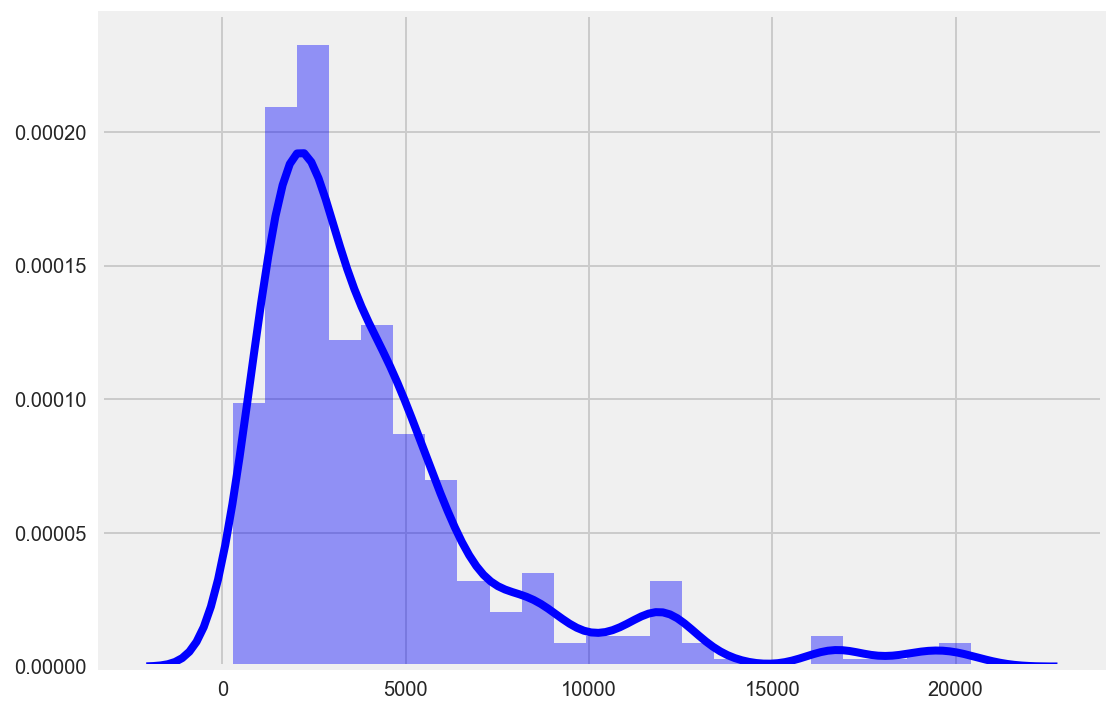

In [8]:
nz = (peak_by_motif != 0).sum().sum()
print("Number of nonzero entries:", (peak_by_motif != 0).sum().sum())
print("Density:", 1.0*nz/peak_by_motif.size)
sns.distplot((peak_by_motif != 0).sum())

('Number of nonzero entries:', 1694416)
('Density:', 0.058707667403970355)


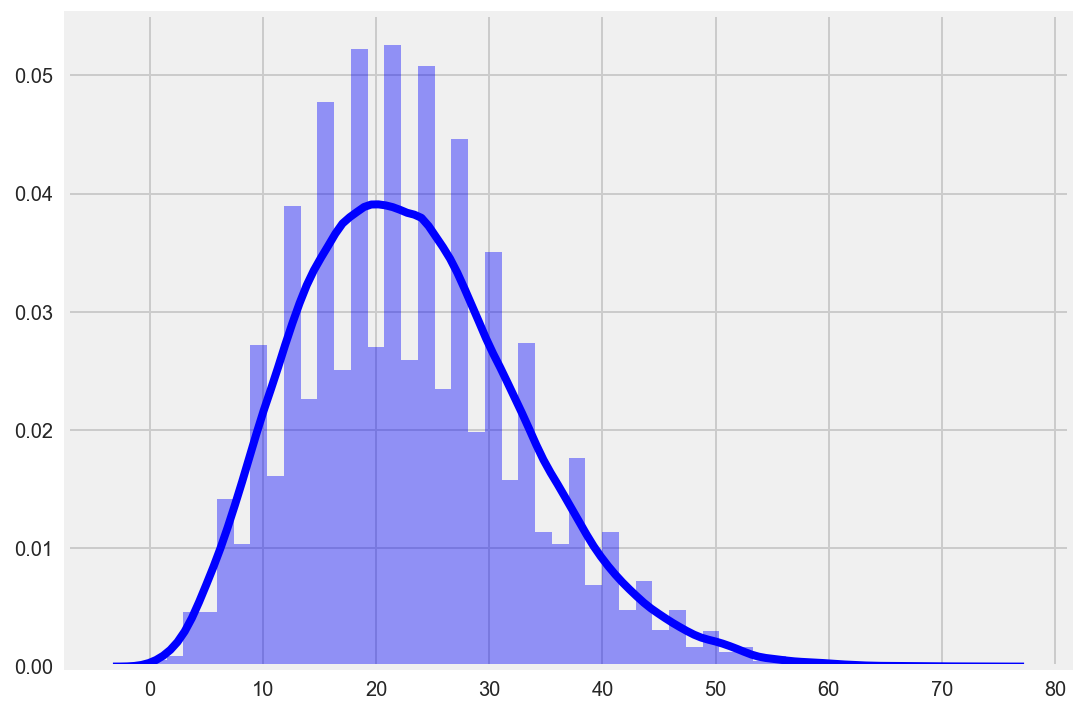

In [9]:
nz = (peak_by_motif != 0).sum(axis=1).sum()
print("Number of nonzero entries:", (peak_by_motif != 0).sum(axis=1).sum())
print("Density:", 1.0*nz/peak_by_motif.size)
sns.distplot((peak_by_motif != 0).sum(axis=1))

In [10]:
(peak_by_motif != 0).sum()

ap1.motif           12667
ap2.motif            7063
ap2gamma.motif       6509
ap4.motif            4440
ar-half.motif        5703
are-fox.motif        3381
are.motif            2850
arnt.motif           1363
ascl1.motif          6016
atf1.motif           2364
atf2.motif           2842
atf3.motif          11884
atf4.motif           3236
atf7.motif           2600
atoh1.motif          3641
bach1.motif          8327
bach2.motif         11669
bapx1.motif          2287
barx1.motif           993
batf.motif          12044
batf3-irf8.motif     4145
bcl6.motif           4871
bhlhe40.motif        1826
bmal.motif           2350
bmyb.motif           1540
boris.motif         16485
brachyury.motif      1347
brn1.motif           1523
brn2.motif            962
bzip-irf.motif       4704
                    ...  
zeb1.motif           2353
zfp281.motif        17175
zfp3.motif           2836
zfp809.motif        10358
zfx.motif            3206
zic.motif            5314
zic3.motif          10514
zkscan1.moti

In [11]:
((peak_by_motif == 0).sum() == peak_by_motif.shape[0]).sum()

0

In [19]:
print((peak_by_motif > 1).sum()).sum()
print((peak_by_motif>0).sum()).sum()


390590
1694416


## Some plotting of the peaks themselves

In [22]:
anno_df = pd.read_csv(motif_params["name"] + ".anno" ,sep="\t",index_col=0)

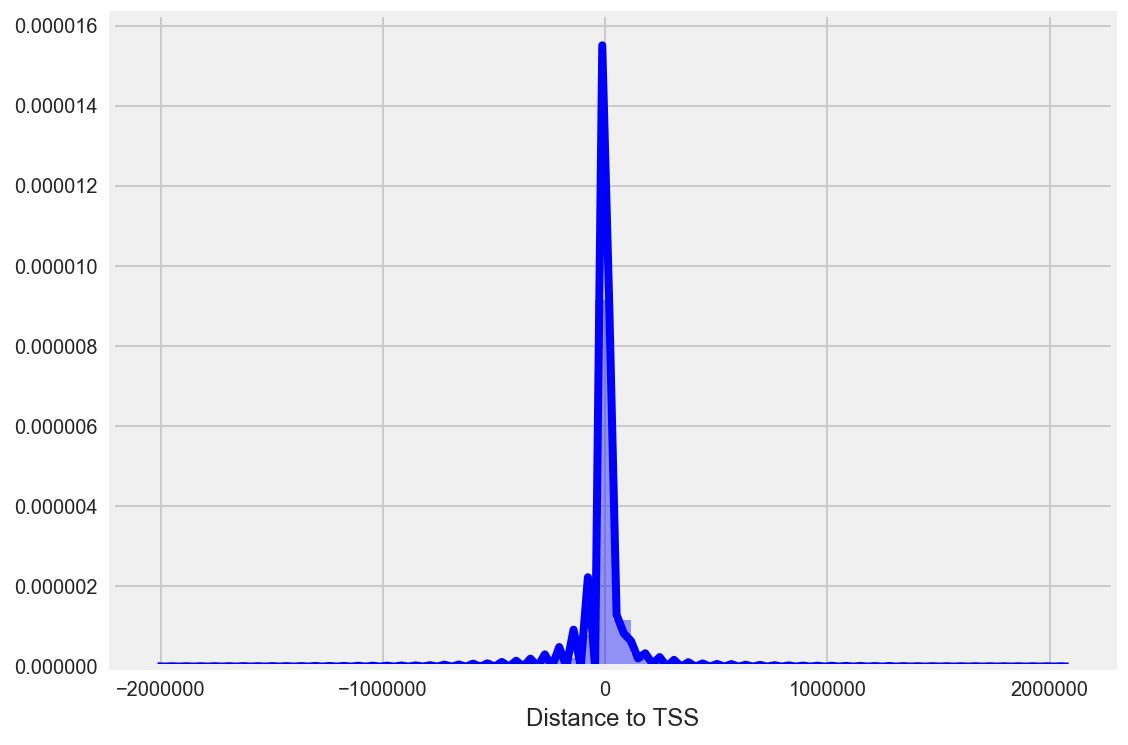

In [23]:
sns.distplot(anno_df[~anno_df["Distance to TSS"].isnull()]["Distance to TSS"])

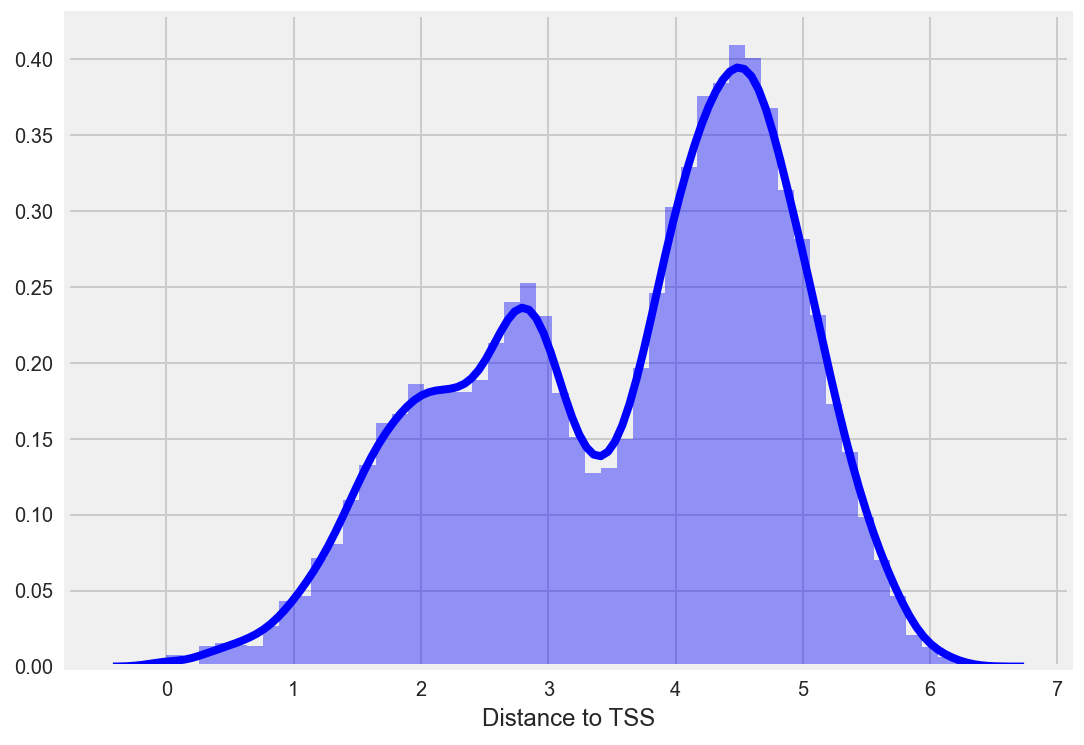

In [24]:
sns.distplot(np.log10(np.abs(anno_df[~anno_df["Distance to TSS"].isnull()]["Distance to TSS"])+1))

Text(0,0.5,u'Normalized Tag Count')

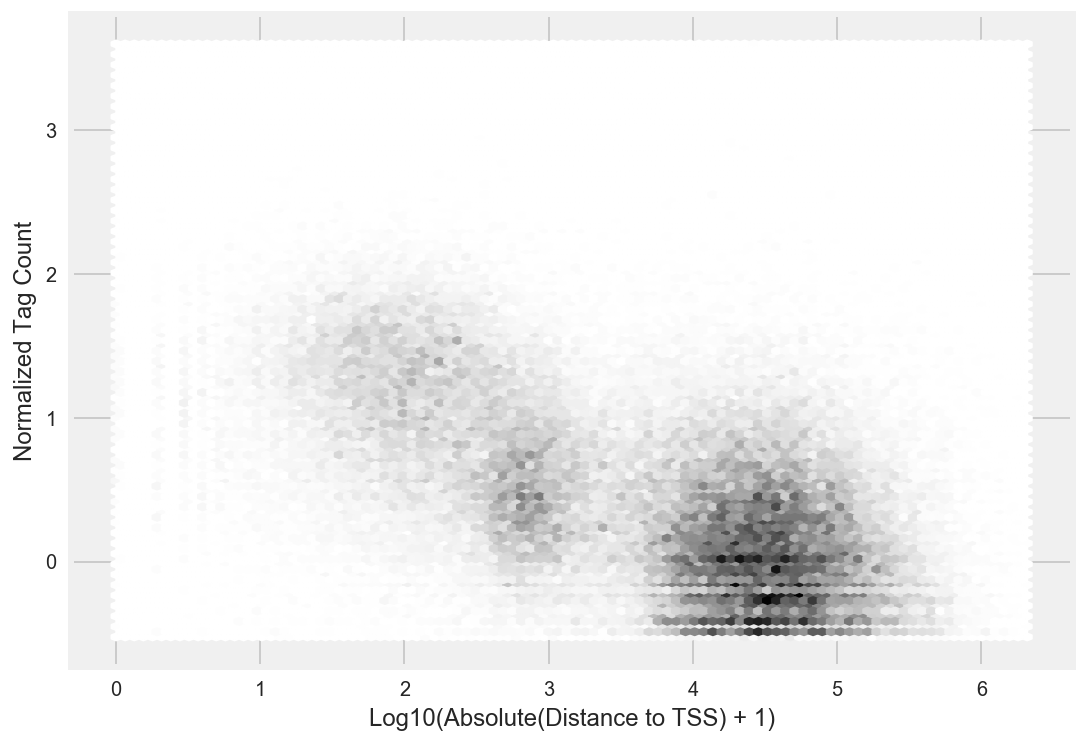

In [25]:
anno_df_nonull = anno_df[~anno_df["Distance to TSS"].isnull()]
plt.hexbin(np.log10(np.abs(anno_df_nonull["Distance to TSS"])+1),np.log10(anno_df_nonull["Normalized Tag Count"]))
plt.xlabel("Log10(Absolute(Distance to TSS) + 1)")
plt.ylabel("Normalized Tag Count")